In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature
import shap
import xgboost

# EXPERIMENT_ID = mlflow.create_experiment('/Users/fpaulsv@cirsa.com/MLflow_example')
EXPERIMENT_ID = mlflow.set_experiment('/Users/fpaulsv@cirsa.com/MLflow_example').experiment_id

In [0]:
X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)
predictions = model.predict(X_train)
signature = infer_signature(X_train, predictions)
eval_data = X_test.copy()
eval_data["target"] = y_test.copy()

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
2024/01/16 11:38:13 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/01/16 11:38:13 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/01/16 11:38:13 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is T

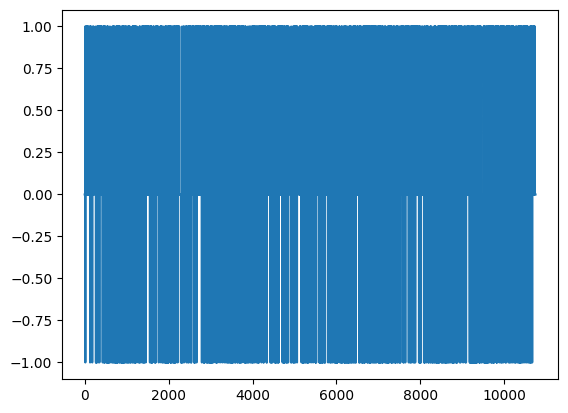

In [0]:
#mlflow.autolog() # log_models: bool = True, log_datasets: bool = True
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='ex4') as run:
  mlflow.log_requirements()
  model_info = mlflow.sklearn.log_model(model, "model", signature=signature)  
  result = mlflow.evaluate( model_info.model_uri, eval_data,
                            targets="target", model_type= 'classifier', evaluators=["default"])
  #
  y_pred_xgb = model.predict(X_test)
  acc_knn = accuracy_score(y_test, y_pred_xgb)
  mlflow.log_metric("test_accuracy_score", acc_knn)
  #
  plt.plot(y_test - y_pred_xgb)
  plt.savefig("residuals_plot.png")
  mlflow.log_artifact("residuals_plot.png") 

In [0]:

# Find experiment ID
results = mlflow.search_experiments()
records = [vars(experiment) for experiment in results]
df = pd.DataFrame.from_records(records)
df[['_lifecycle_stage', '_experiment_id', '_name']]

# list columns separating per group:
# column_groups = { 'metrics': 'metrics.', 'params': 'params.', 'tags': 'tags.' }
# grouped_columns = {group: experiments.filter(like=prefix, axis=1).columns.tolist() for group, prefix in column_groups.items()}
# for group, columns in grouped_columns.items(): print(columns); print()

# List all runs of the experiment
experiments = mlflow.search_runs(experiment_ids = [EXPERIMENT_ID] ) # tags.mlflow.runName	
display( experiments[['experiment_id','run_id','artifact_uri','tags.mlflow.runName','tags.mlflow.databricks.notebookPath','metrics.test_accuracy_score']] )

# Load model
model_loaded = mlflow.pyfunc.load_model('runs:/5db89e9e42e744019bd5b03224787342/model')



['metrics.test_accuracy_score', 'metrics.training_recall_score', 'metrics.training_precision_score', 'metrics.training_f1_score', 'metrics.training_score', 'metrics.training_roc_auc', 'metrics.accuracy_score_X_test', 'metrics.training_accuracy_score', 'metrics.training_log_loss']

['params.metric_params', 'params.metric', 'params.n_jobs', 'params.algorithm', 'params.n_neighbors', 'params.p', 'params.leaf_size', 'params.weights']

['tags.mlflow.databricks.cluster.id', 'tags.mlflow.databricks.notebookRevisionID', 'tags.mlflow.databricks.workspaceID', 'tags.mlflow.source.name', 'tags.mlflow.databricks.notebookPath', 'tags.mlflow.databricks.gitRepoReference', 'tags.mlflow.log-model.history', 'tags.mlflow.databricks.notebook.commandID', 'tags.mlflow.databricks.webappURL', 'tags.mlflow.source.type', 'tags.mlflow.databricks.cluster.libraries', 'tags.mlflow.databricks.gitRepoProvider', 'tags.mlflow.databricks.gitRepoCommit', 'tags.estimator_name', 'tags.mlflow.user', 'tags.mlflow.databricks.gi

,experiment_id,run_id,artifact_uri,tags.mlflow.runName,tags.mlflow.databricks.notebookPath,metrics.test_accuracy_score
0,3791571421799522,5db89e9e42e744019bd5b03224787342,dbfs:/databricks/mlflow-tracking/3791571421799...,ex2,/Repos/fpaulsv@cirsa.com/SocialGames.BricksCon...,0.765625
1,3791571421799522,c6f1becf84f148cb90b0c05c762fe2d9,dbfs:/databricks/mlflow-tracking/3791571421799...,ex1,/Repos/fpaulsv@cirsa.com/SocialGames.BricksCon...,NaN
2,3791571421799522,03d4d51215b743779b236f2a904ac693,dbfs:/databricks/mlflow-tracking/3791571421799...,ex1,/Repos/fpaulsv@cirsa.com/SocialGames.BricksCon...,NaN
3,3791571421799522,9286356beea84969b9bc0a1889050a23,dbfs:/databricks/mlflow-tracking/3791571421799...,mysterious-finch-987,/Repos/fpaulsv@cirsa.com/SocialGames.BricksCon...,NaN


In [0]:
# After you've played in "Experiments", Save model in "Models"
new_model_version = mlflow.register_model(model_uri='dbfs:/databricks/mlflow-tracking/3791571421799522/5db89e9e42e744019bd5b03224787342/artifacts/model'
                                          , name='FirstModel')

from mlflow.tracking import MlflowClient
client = MlflowClient()
client.transition_model_version_stage( name='FirstModel', version=new_model_version.version, stage="Staging" )


Registered model 'FirstModel' already exists. Creating a new version of this model...
2024/01/14 17:21:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FirstModel, version 4
Created version '4' of model 'FirstModel'.


<ModelVersion: aliases=[], creation_timestamp=1705252876297, current_stage='Staging', description='', last_updated_timestamp=1705252882703, name='FirstModel', run_id='', run_link='', source='dbfs:/databricks/mlflow-tracking/3791571421799522/5db89e9e42e744019bd5b03224787342/artifacts/model', status='READY', status_message='', tags={}, user_id='4186803279842908', version='4'>